### (Function) Get table meta data

In [1]:
def generate_meta_info_df(df):
    feature_info = []
    for col in df.columns:
        info = { 
            'feature': col,
            'n_unique': len(set(df[col])),
            'datatype': df[col].dtype
        
        }
        feature_info.append(info)
    feature_info_df = pd.DataFrame(feature_info)  
    return feature_info_df

### (Function) Find the optimal skew for each feature

In [2]:
from scipy.stats import skew, skewtest, normaltest
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import math
def clean_null(dataset, col_drop_on_null_over = 500):
   
    dataset=pd.DataFrame(dataset)
    dataset = dataset.drop([col for col in dataset.columns
                                    if sum(dataset[col].isnull()) >col_drop_on_null_over],axis =1)
    return dataset

def check_true_numeric(dataset, col_drop_on_unique_less_then = 15):
    dataset=pd.DataFrame(dataset)
    for col in dataset.columns:
        if len(set(dataset[col])) < col_drop_on_unique_less_then:
            dataset[col] = dataset[col].astype('object')
    return dataset

def fill_null(dataset):
    dataset=pd.DataFrame(dataset)
    for col in dataset.columns:
        dataset[col] = dataset[col].where(dataset[col].isnull() == False,dataset[col].mean())
    return dataset    
    
def  p_value_test(dataset, col_drop_on_null_over = 500, col_drop_on_unique_less_then = 15):
    dataset = clean_null(dataset, col_drop_on_null_over = col_drop_on_null_over)
    dataset = check_true_numeric(dataset, col_drop_on_unique_less_then = col_drop_on_unique_less_then)
    numeric_df = dataset.drop([col for col in dataset.columns 
                 if dataset[col].dtype =='O'] ,axis =1)
    numeric_df = numeric_df.astype('float64')
    numeric_df = fill_null(numeric_df)
    skewed_df = numeric_df.drop([col for col in numeric_df.columns 
        if (skewtest(numeric_df[col]).pvalue > 0.05 or abs(skew(numeric_df[col]))< 0.75)], axis = 1)
    non_skewed_df = numeric_df.drop([col for col in numeric_df.columns 
        if (skewtest(numeric_df[col]).pvalue <= 0.05 and abs(skew(numeric_df[col]))>= 0.75)], axis = 1)
    return (skewed_df, non_skewed_df)   


def deskew(dataset, col_drop_on_null_over = 500, col_drop_on_unique_less_then = 15):
    skewed_df, non_skewed_df  = p_value_test(dataset, col_drop_on_null_over = col_drop_on_null_over, \
                             col_drop_on_unique_less_then = col_drop_on_unique_less_then)
    deskewed_df = skewed_df.copy()
    for i, col in enumerate(skewed_df.columns): 
        counter = 1
        p_val = 0
        prev_pval=-1
        min_alpha = -1 * np.min(skewed_df[col])
        while counter < 10000 and p_val > prev_pval:
            prev_pval=p_val
            counter = counter +1
            alpha = counter + min_alpha
            test_data = np.log(alpha+skewed_df[col])
            p_val = skewtest(test_data).pvalue             
        deskewed_df[col]= np.log((alpha - 1)+skewed_df[col])
    
    deskewed_df = deskewed_df.merge(non_skewed_df, left_index=True, right_index=True)
    return deskewed_df

def deskew_plot(dataset, col_drop_on_null_over = 500, col_drop_on_unique_less_then = 15):
    skewed_df, non_skewed_df = p_value_test(dataset, col_drop_on_null_over = col_drop_on_null_over, \
                             col_drop_on_unique_less_then = col_drop_on_unique_less_then)
    
    fig, axes = plt.subplots(5,4)
    axes = axes.flatten()
    fig.set_size_inches(23, 30)
    fig.suptitle('Distribution of skewness over different Alpha')
    deskewed_df = skewed_df.copy()
    alpha_list=[]
    for i, col in enumerate(skewed_df.columns): 
        a_list=[]
        s_list=[]
        pvals = []
        counter = 1
        p_val = 0
        prev_pval=-1
        min_alpha = -1 * np.min(skewed_df[col])
        while counter < 10000 and p_val > prev_pval:
            prev_pval=p_val
            counter = counter +1
            alpha = counter + min_alpha
            test_data = np.log(alpha+skewed_df[col])
            p_val = skewtest(test_data).pvalue 
            s = skew(test_data)
            pvals.append(p_val)
            a_list.append(alpha)
            s_list.append(s)
            
        deskewed_df[col]= np.log((alpha - 1)+skewed_df[col])
        alpha_list.append((alpha - 1))
        fig.add_subplot(5,4, 1+i)
        plt.plot(a_list, s_list)
        #axes[i].axvline((alpha - 1),linewidth=1, color='r')
        plt.xlabel("alpha")
        plt.ylabel("skew")
        min_alpha_label = math.ceil(min(a_list))
        max_alpha_label = math.ceil(max(a_list))+1
        plt.xlim(min_alpha_label,max_alpha_label)
        plt.title(col)
                
    fig, axes = plt.subplots(5,4)
    axes = axes.flatten()
    fig.set_size_inches(20, 25)
    fig.suptitle('Distribution of Numeric Features')
    for i, col in enumerate(deskewed_df.columns):
        feature = deskewed_df[col]
        sns.distplot(feature, label=col, ax=axes[i])
        axes[i].axvline(feature.mean(),linewidth=1)
        axes[i].axvline(feature.median(),linewidth=1, color='r')
        axes[i].axvline(feature.mode().values[0],linewidth=1, color='g')

In [3]:
from os import chdir
chdir('../')
%matplotlib inline
from lib import *

In [4]:
train = pd.read_csv('./data/train.csv')
zoning = pd.read_csv('./data/zoning.csv')
listing = pd.read_csv('./data/listing.csv')
sale = pd.read_csv('./data/sale.csv')

In [5]:
train.columns.values

array(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond',
       'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir',
       'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'Pav

In [6]:
column_500null = []
train_cleaning = train.copy()
for col in train.columns:
    if sum(train[col].isnull()) > 500:
        train_cleaning.drop(col,axis =1, inplace=True)
        column_500null.append(col)
column_500null

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [7]:
train_cleaning.get_dtype_counts()

float64     3
int64      35
object     38
dtype: int64

In [8]:
feature_info_df = train_cleaning.copy()
feature_info = []
for col in feature_info_df.columns:
    info = { 
        'feature': col,
        'n_unique': len(set(feature_info_df[col])),
        'datatype': feature_info_df[col].dtype
    }
    feature_info.append(info)
feature_info_df = pd.DataFrame(feature_info)  
feature_info_df.head()

,datatype,feature,n_unique
0,int64,Id,1460
1,int64,MSSubClass,15
2,object,MSZoning,5
3,float64,LotFrontage,369
4,int64,LotArea,1073


In [9]:
feature_info_int_df = feature_info_df[feature_info_df['datatype']=='int64']
feature_info_int_df.head()

,datatype,feature,n_unique
0,int64,Id,1460
1,int64,MSSubClass,15
4,int64,LotArea,1073
16,int64,OverallQual,10
17,int64,OverallCond,9


In [10]:
object_list = []
for i in range(0,len(feature_info_int_df)):
   
    if feature_info_int_df['n_unique'].iloc[i] <15:
        object_list.append(feature_info_int_df['feature'].iloc[i])
object_list   

['OverallQual',
 'OverallCond',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'PoolArea',
 'MoSold',
 'YrSold']

In [11]:
for col in train_cleaning.columns:
    if col in object_list:
        train_cleaning[col] = train_cleaning[col].astype('object')

In [12]:
train_cleaning.get_dtype_counts()

float64     3
int64      21
object     52
dtype: int64

In [13]:
for col in train_cleaning.columns:
    if train_cleaning[col].dtype =='int64':
        train_cleaning[col]= train_cleaning[col].astype('float64')

In [14]:
train_cleaning.get_dtype_counts()

float64    24
object     52
dtype: int64

In [15]:
num_df = train_cleaning.copy()
cat_df = train_cleaning.copy()
for col in num_df.columns:
    if num_df[col].dtype == 'O':
        num_df=num_df.drop(col, axis = 1)
        
for col in cat_df.columns:
    if cat_df[col].dtype == 'float64':
        cat_df=cat_df.drop(col, axis = 1) 

In [16]:
num_null_list = []
for col in num_df.columns:
    if sum(num_df[col].isnull()) > 0:
        num_null_list.append(col)
        print(col,sum(num_df[col].isnull()))  

LotFrontage 259
MasVnrArea 8
GarageYrBlt 81


In [17]:
for col in num_null_list:
    print('mean: ',num_df[col].mean())
    print('median: ', num_df[col].median())
    num_df[col] = num_df[col].\
    where(num_df[col].isnull() == False,num_df[col].mean())

mean:  70.049958368
median:  69.0
mean:  103.685261708
median:  0.0
mean:  1978.50616389
median:  1980.0


/opt/conda/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


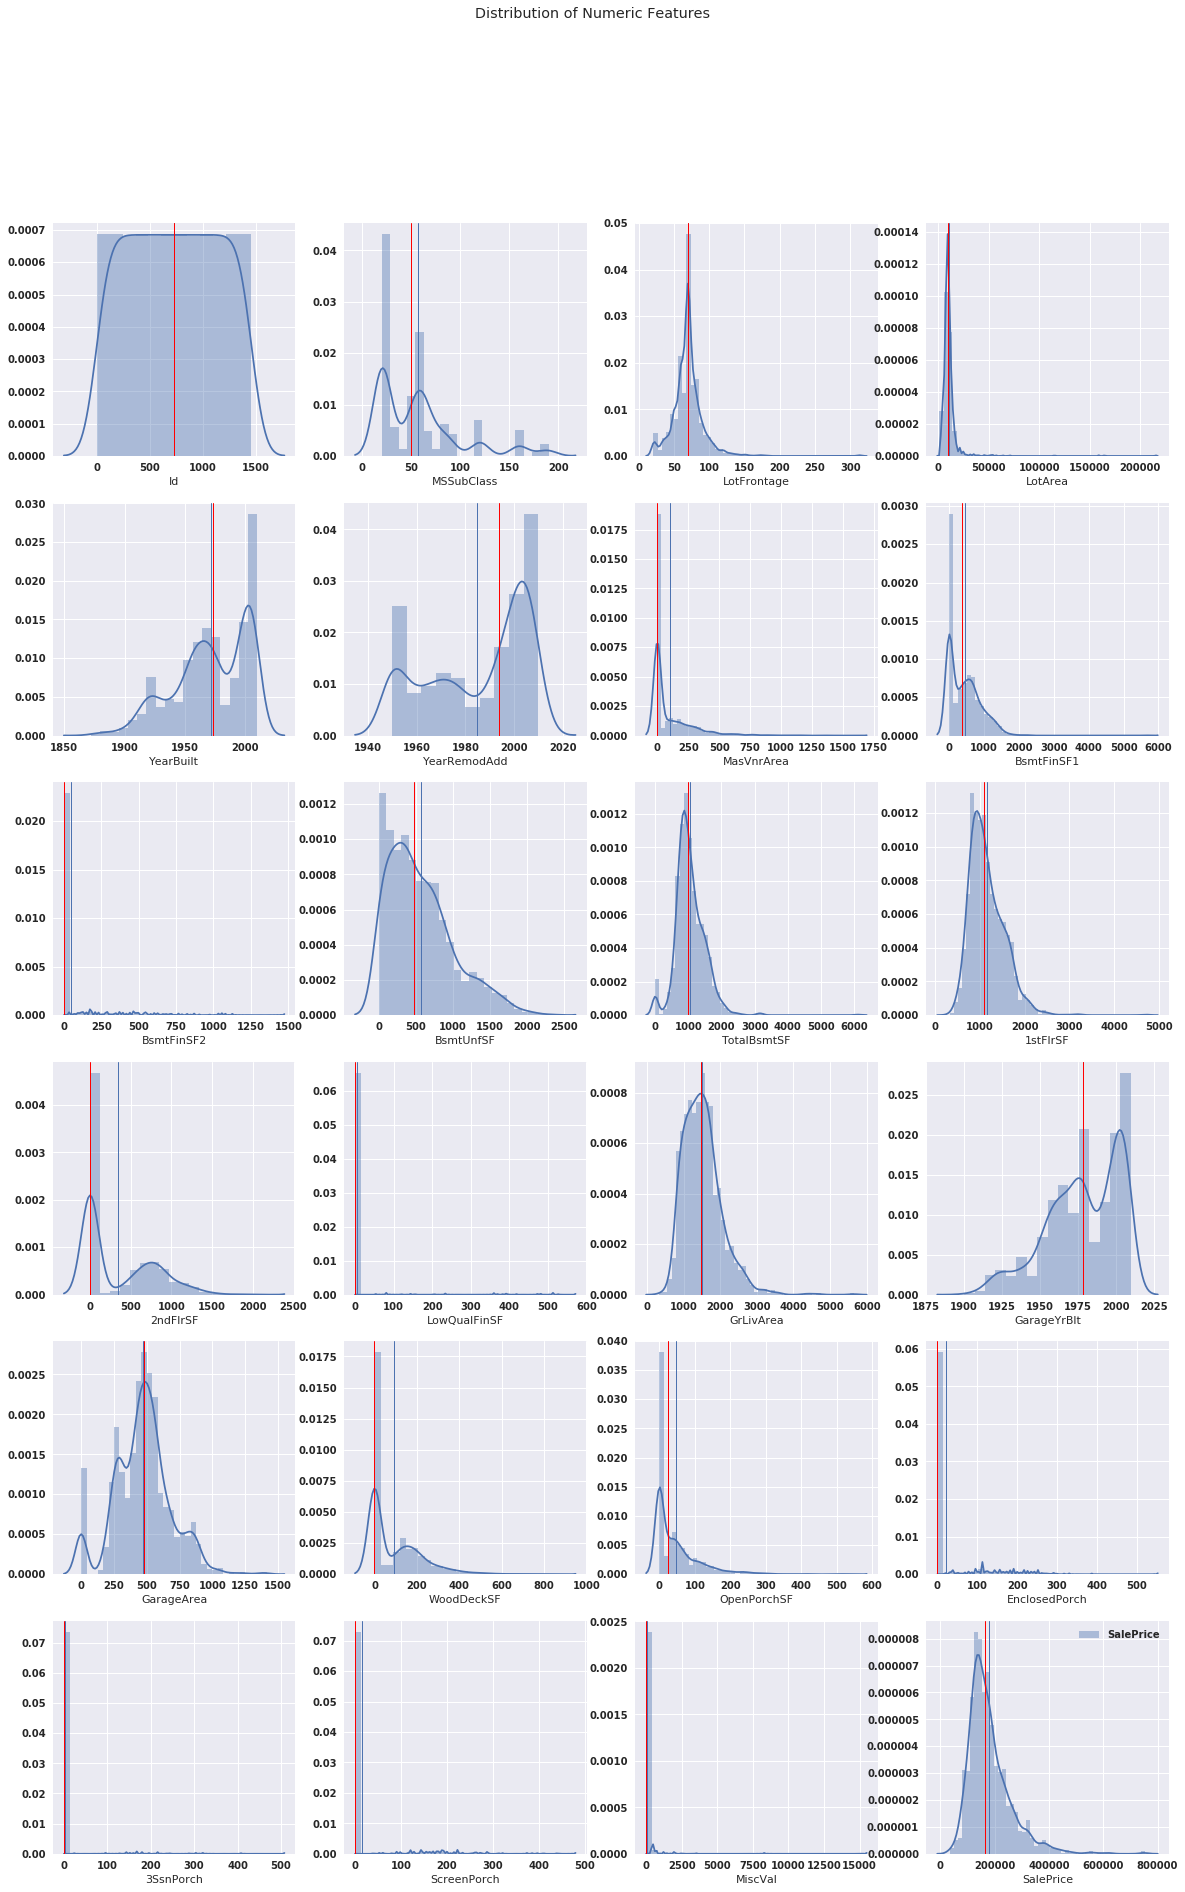

In [18]:
fig, axes = plt.subplots(6,4)
axes = axes.flatten()
fig.set_size_inches(20, 30)
fig.suptitle('Distribution of Numeric Features')
for i, col in enumerate(num_df.columns):
    feature = num_df[col]
    sns.distplot(feature, label=col, ax=axes[i])
    axes[i].axvline(feature.mean(),linewidth=1)
    axes[i].axvline(feature.median(),linewidth=1, color='r')
    #axes[i].axvline(feature.mode().values[0],linewidth=1, color='g')
    plt.legend()

In [19]:
from scipy.stats import skew, skewtest, normaltest
for col in num_df.columns:
    print(col,' P_Value: ', skewtest(num_df[col]).pvalue)

Id  P_Value:  0.316341487643
MSSubClass  P_Value:  1.24918266348e-63
LotFrontage  P_Value:  2.6090023372e-117
LotArea  P_Value:  0.0
YearBuilt  P_Value:  6.22030882923e-19
YearRemodAdd  P_Value:  8.42769989673e-14
MasVnrArea  P_Value:  6.56783194754e-132
BsmtFinSF1  P_Value:  1.43066665407e-79
BsmtFinSF2  P_Value:  6.15685804683e-201
BsmtUnfSF  P_Value:  2.33355145798e-35
TotalBsmtSF  P_Value:  2.27495311639e-70
1stFlrSF  P_Value:  7.79799216251e-62
2ndFlrSF  P_Value:  2.26915773431e-29
LowQualFinSF  P_Value:  0.0
GrLivArea  P_Value:  3.05552268259e-61
GarageYrBlt  P_Value:  1.1288259064e-21
GarageArea  P_Value:  0.00515907468289
WoodDeckSF  P_Value:  2.3595087047e-71
OpenPorchSF  P_Value:  2.97650378021e-116
EnclosedPorch  P_Value:  1.55656001955e-151
3SsnPorch  P_Value:  0.0
ScreenPorch  P_Value:  1.09962467059e-195
MiscVal  P_Value:  0.0
SalePrice  P_Value:  1.34065850378e-90


In [20]:
from scipy.stats import skew, skewtest, normaltest
skewed_list = []
for col in num_df.columns:
    if abs(skew(num_df[col])) > 0.75:
        skewed_list.append(col)
print(skewed_list)    

['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'SalePrice']


In [21]:
simple_deskewed_num_df = num_df.copy()
for col in skewed_list:
    simple_deskewed_num_df[col] = np.log(1+ simple_deskewed_num_df[col])
    
skewed_list = {}
for col in simple_deskewed_num_df.columns:
    if abs(skew(simple_deskewed_num_df[col])) > 0.75:
        ##print(col)
        ##print(skew(simple_deskewed_num_df[col]))
        ##print(simple_deskewed_num_df[col])
        skewed_list[col] = skew(simple_deskewed_num_df[col])
        
print(skewed_list)

{'MiscVal': 5.165389977878334, 'EnclosedPorch': 2.110104183261533, 'ScreenPorch': 3.1471712168455683, 'BsmtUnfSF': -2.18425653050519, '3SsnPorch': 7.727025709215359, 'LowQualFinSF': 7.452649617407249, 'TotalBsmtSF': -5.149372577588974, 'LotFrontage': -0.8910600587933171, 'BsmtFinSF2': 2.521100187789297}


In [22]:
deskewed_df = deskew(train_cleaning)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


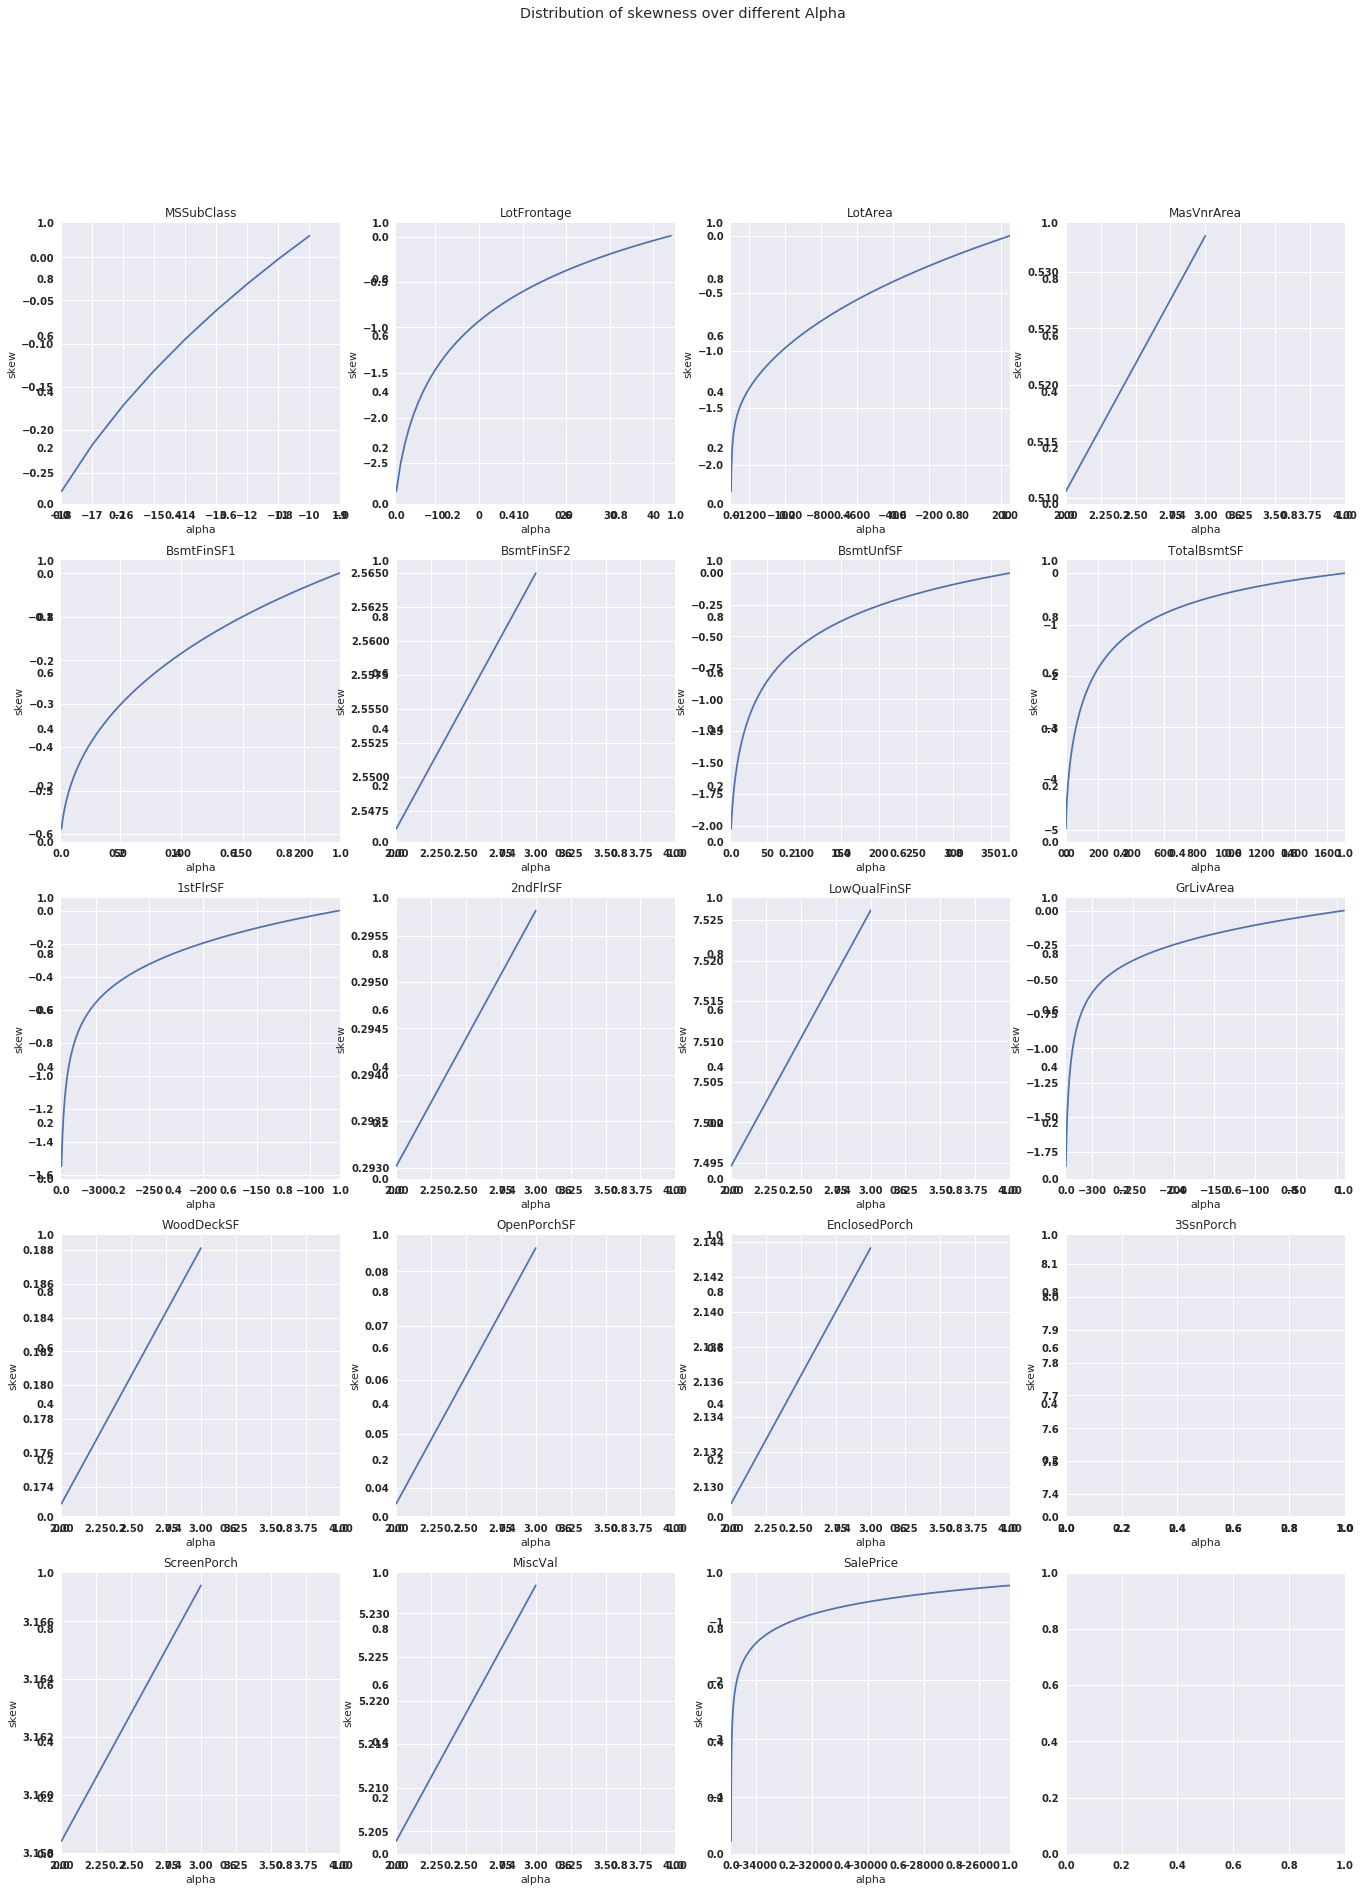

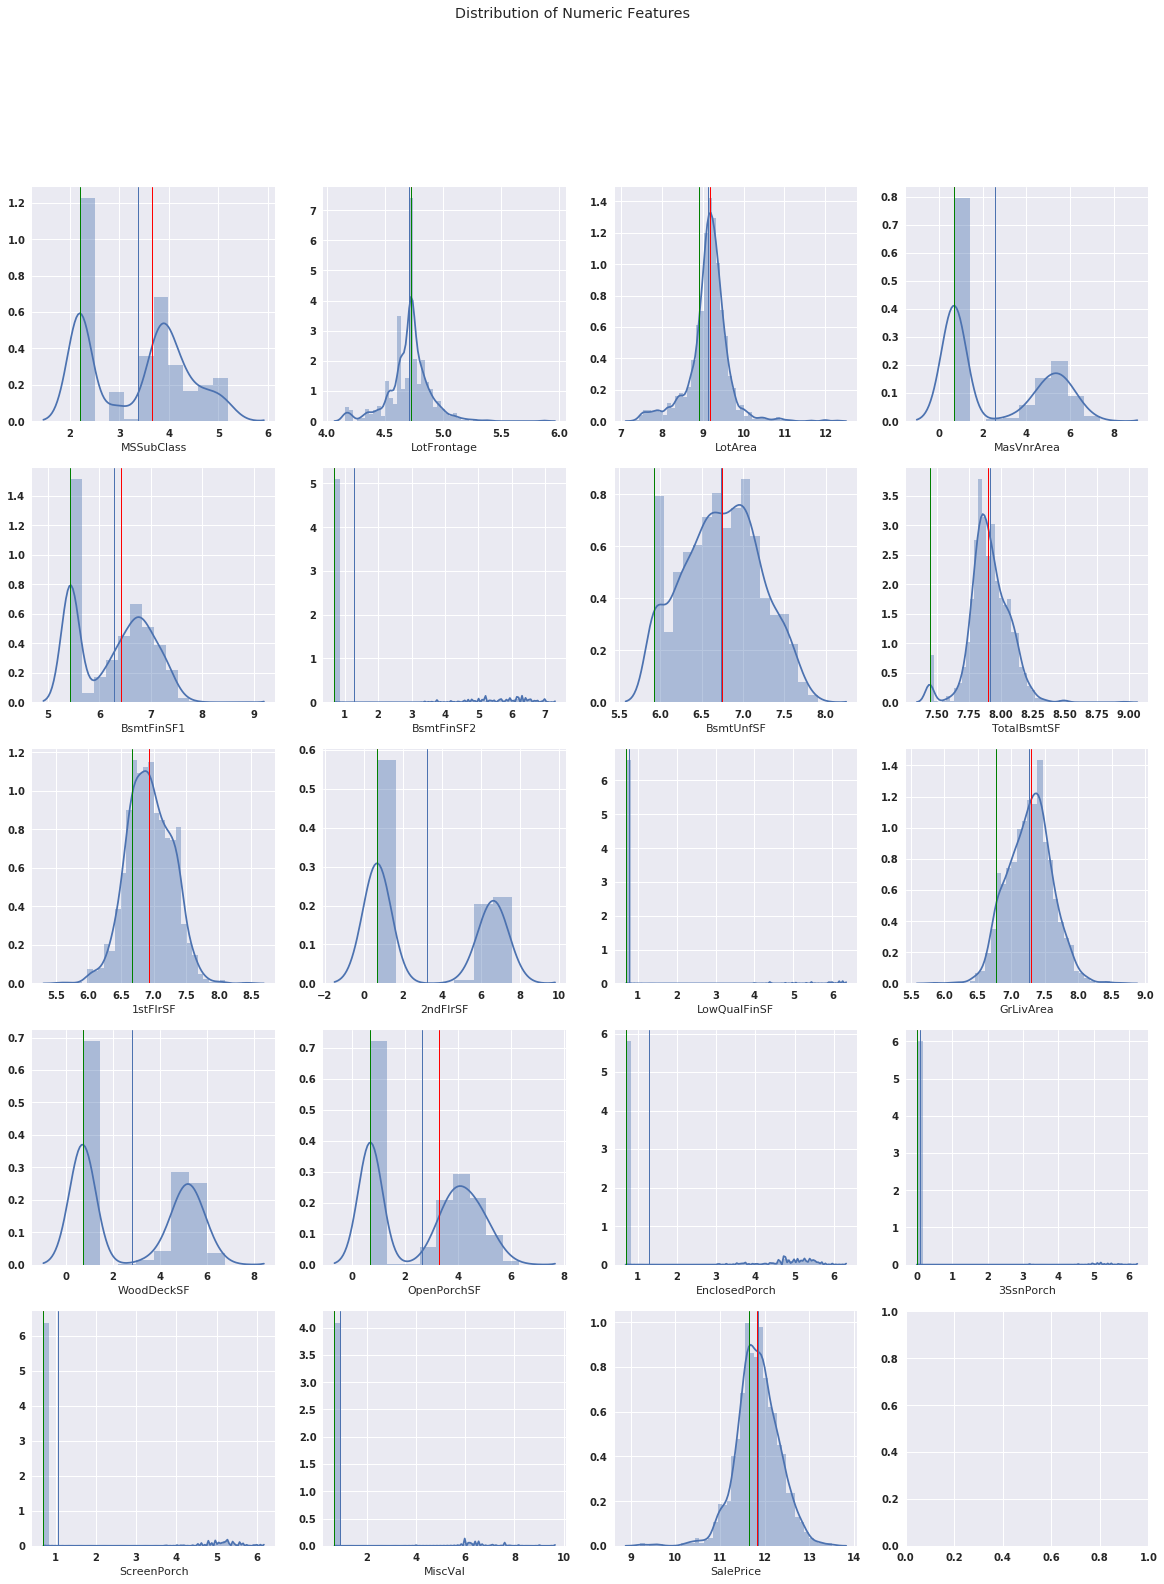

In [23]:
deskew_plot(train_cleaning)

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


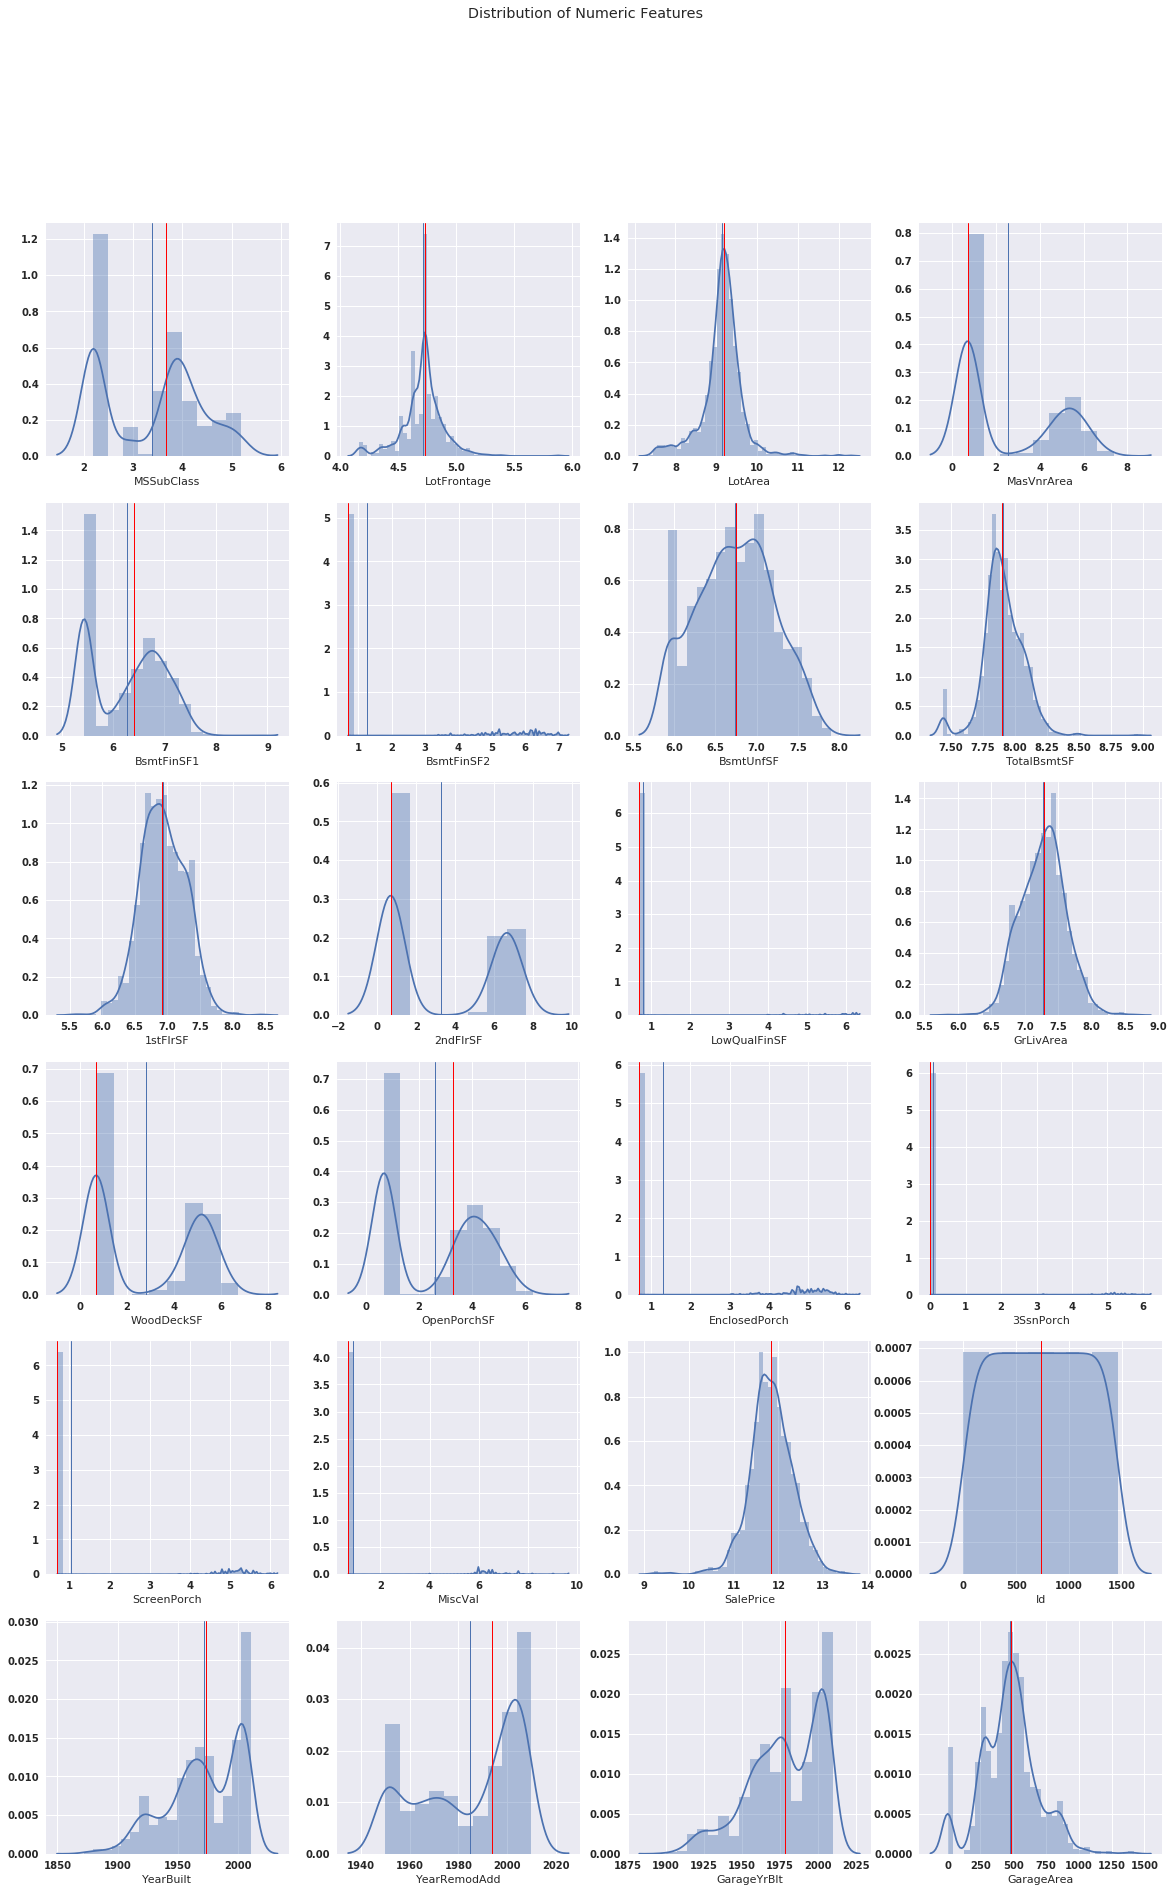

In [24]:
fig, axes = plt.subplots(6,4)
axes = axes.flatten()
fig.set_size_inches(20, 30)
fig.suptitle('Distribution of Numeric Features')
for i, col in enumerate(deskewed_df.columns):
    feature = deskewed_df[col]
    sns.distplot(feature, label=col, ax=axes[i])
    axes[i].axvline(feature.mean(),linewidth=1)
    axes[i].axvline(feature.median(),linewidth=1, color='r')
    #axes[i].axvline(feature.mode().values[0],linewidth=1, color='g')

In [25]:
cat_nan_count={}
for col in cat_df.columns:
    if sum(cat_df[col].isnull())> 0: 
        cat_nan_count[col] = sum(cat_df[col].isnull())
print(cat_nan_count)    

{'BsmtFinType2': 38, 'GarageCond': 81, 'BsmtExposure': 38, 'GarageQual': 81, 'GarageFinish': 81, 'GarageType': 81, 'BsmtQual': 37, 'BsmtFinType1': 37, 'BsmtCond': 37, 'MasVnrType': 8, 'Electrical': 1}


In [26]:
## Replace null value in those features with mode
for col in cat_nan_count.keys():
    cat_df[col] = cat_df[col].where(cat_df[col].isnull()== False, cat_df[col].mode()[0])

In [27]:
cat_df.dtypes.value_counts()

object    52
dtype: int64

In [28]:
for col in cat_df.columns:
    cat_df[col] = cat_df[col].astype('object')
cat_df_dummies = pd.get_dummies(cat_df)
cat_df_dummies.shape

(1460, 325)

In [29]:
cat_df_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,0,1,1,0,0,...,0,0,0,1,0,0,0,0,1,0


In [30]:
deskewed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 24 columns):
MSSubClass       1460 non-null float64
LotFrontage      1460 non-null float64
LotArea          1460 non-null float64
MasVnrArea       1460 non-null float64
BsmtFinSF1       1460 non-null float64
BsmtFinSF2       1460 non-null float64
BsmtUnfSF        1460 non-null float64
TotalBsmtSF      1460 non-null float64
1stFlrSF         1460 non-null float64
2ndFlrSF         1460 non-null float64
LowQualFinSF     1460 non-null float64
GrLivArea        1460 non-null float64
WoodDeckSF       1460 non-null float64
OpenPorchSF      1460 non-null float64
EnclosedPorch    1460 non-null float64
3SsnPorch        1460 non-null float64
ScreenPorch      1460 non-null float64
MiscVal          1460 non-null float64
SalePrice        1460 non-null float64
Id               1460 non-null float64
YearBuilt        1460 non-null float64
YearRemodAdd     1460 non-null float64
GarageYrBlt      1460 non-null floa

In [31]:
train_cleaned = num_df.merge(cat_df_dummies,left_index=True, right_index=True)
train_cleaned_deskewed = deskewed_df.merge(cat_df_dummies,left_index=True, right_index=True)

In [32]:
target = train_cleaned['SalePrice']
features =  train_cleaned.drop('SalePrice', axis = 1)
features.shape

(1460, 348)

In [33]:
target_deskewed = train_cleaned_deskewed['SalePrice']
features_deskewed =  train_cleaned_deskewed.drop('SalePrice', axis = 1)
features_deskewed.shape

(1460, 348)

In [73]:
pickled_features_deskewed = pd.DataFrame.to_pickle(features_deskewed,'./pickled/pickled_features_deskewed')
pickled_target_deskewed = pd.DataFrame.to_pickle(target_deskewed,'./pickled/pickled_target_deskewed')
pickled_features = pd.DataFrame.to_pickle(features,'./pickled/pickled_features')
pickled_target = pd.DataFrame.to_pickle(target,'./pickled/pickled_target')
pickled_cat = pd.DataFrame.to_pickle(cat_df,'./pickled/pickled_cat')

In [36]:
generate_meta_info_df(train_cleaned)

,datatype,feature,n_unique
0,float64,Id,1460
1,float64,MSSubClass,15
2,float64,LotFrontage,111
3,float64,LotArea,1073
4,float64,YearBuilt,112
5,float64,YearRemodAdd,61
6,float64,MasVnrArea,328
7,float64,BsmtFinSF1,637
8,float64,BsmtFinSF2,144
9,float64,BsmtUnfSF,780
